# CSCI 4050U - Final Project

Group ID: 49

Brandon Viaje: 100912514

Ethan Warriner: 100869513

# Overview

## Case Study: NLP Architectures for Sentiment Analysis

<img src="https://www.displayr.com/wp-content/uploads/2024/10/3-tips-sentiment-analysis-1024x625.png" width="500" height="auto">

## Problem Description

In this project, we focus on the task of binary sentiment analysis on user-written movie reviews, with the goal of determining whether each review expresses a positive or negative sentiment. To identify the best-performing NLP architecture for this task, we compare multiple models under the same dataset and experimental conditions. This allows us to evaluate how effectively each architecture learns sentiment-related patterns in text.

Each review is labeled as either **positive** or **negative**, and the goal is for a model to learn patterns in the text that indicate sentiment.

### Learning Task
- **Input:** A movie review (raw text)
- **Output:** Sentiment label (0 = negative, 1 = positive)
- **Task Type:** Supervised binary classification
- **Evaluation Metric:** Accuracy on the test set

### Motivation
Sentiment analysis is widely used in real-world applications such as review filtering, customer analytics, and user feedback understanding.  

Because it requires models to understand context, tone, and long-range text dependencies, it serves as an excellent benchmark to compare NLP architectures.

### Models Compared
We train and evaluate four different neural network architectures:

1. **Simple RNN**  
   - Baseline sequence model  
   - Limited ability to handle long-term dependencies
2. **LSTM (Long Short-Term Memory)**
   - Designed to handle long-range dependencies  
   - Historically strong for NLP tasks
3. **GRU (Gated Recurrent Unit)**  
   - Uses gates for more effective memory retention  
   - Faster and lighter than LSTM
4. **DistilBERT**  
   - A modern transformer-based architecture  
   - Pretrained on massive text corpora  
   - Expected to outperform RNN-based models

### What This Study Aims to Answer
This comparative study evaluates how each model performs under the same dataset and conditions, focusing on:

- **How do RNN, GRU, LSTM, and DistilBERT differ in accuracy?**  
- **Do modern transformer-based models significantly outperform traditional recurrent models?**  
- **What are the trade-offs in terms of training time and model complexity?**

This section defines the learning problem clearly and sets the foundation for the experiments and results that follow.


## Data Description

**Dataset Used:** [IMDB Movie Reviews](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews)  

- **Number of samples:** 50,000 reviews  
- **Classes:** Positive / Negative  

### Preprocessing Steps
1. **Data Loading** :  
   - Load the raw text reviews and labels.  
2. **Data Cleaning** :  
   - Convert text to **lowercase**  
   - Keep only **alphabetic tokens**  
   - **Expand contractions** (e.g., "can't" → "cannot")  
3. **Tokenization** :  
   - Split text into individual words or subwords.  
4. **Build Vocabulary** :  
   - Create a mapping of tokens to integers.  
5. **Integer Encoding** :  
   - Convert tokens into integer sequences for model input.  


**High-Level Pipeline:**  

Text → Tokens → Integers → Tensors


## Models

We will examine four main architectures:

*   **RNNs**
*   **LSTM**
*   **GRU**
*   **Transformers**



# Data Loading


In [ ]:
! pip install lightning > /dev/null
! pip install transformers > /dev/null
! pip install contractions > /dev/null

In [ ]:
# Standard Library
import os
import re
import shutil
import time
import warnings
from collections import Counter

# Third-Party Libraries
import contractions
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
import torch
import torch.nn as nn
from datasets import load_dataset, concatenate_datasets
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer

# PyTorch Utilities
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset, random_split

# PyTorch Lightning
from lightning import LightningDataModule, seed_everything
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch import LightningModule

# TorchMetrics
from torchmetrics.classification import BinaryAccuracy

# Google Colab
from google.colab import drive

# Warning Filters
warnings.filterwarnings("ignore")

In [ ]:
# Mount Drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset Analysis

We will analyze the **IMDB movie review dataset** to better understand its characteristics before training our models.


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/CSCI4050U/IMDB-Dataset.csv")

In [ ]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Content

Our dataset consists of **50,000 rows** with two columns:

1. **Review** – The text of the movie review.  
2. **Sentiment** – The label indicating whether the review is **positive** or **negative**.  

In [ ]:
df.shape

(50000, 2)

In [ ]:
df['sentiment'].unique()

array(['positive', 'negative'], dtype=object)

## Dataset Balanced

As observed, the dataset is **very balanced** between positive and negative reviews.  

- **Positive Reviews:** 25,000  
- **Negative Reviews:** 25,000  

In [ ]:
df['sentiment'].value_counts()

,count
sentiment,
positive,25000
negative,25000


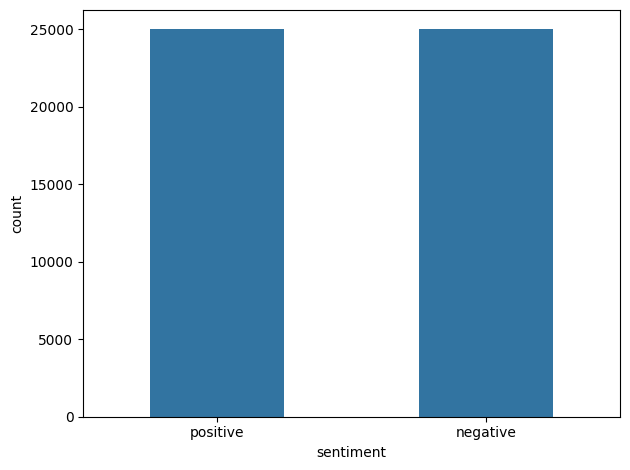

In [ ]:
ax = sns.countplot(x='sentiment', data=df, width=0.5)
ax.tick_params(axis='x', rotation=360)
plt.tight_layout()
plt.show()

# Data Preprocessing: `IMDBPreProcessor`

We create a **preprocessing class** to handle all the necessary steps for preparing the IMDB dataset for modeling.  
This class cleans text, tokenizes reviews, builds a vocabulary, and encodes tokens into integer sequences.

---

### Responsibilities of the `IMDBPreProcessor` Class

1. **Data Cleaning**
   - Expand contractions (e.g., "can't" → "can not")  
   - Convert text to **lowercase**  
   - Keep only **alphabetic tokens** of length 3–50  

2. **Tokenization**
   - Split reviews into tokens using **spaCy**  
   - Remove stopwords unless they are **important words** (`not`, `no`, `never`, `none`, `nothing`, `nowhere`)  
   - Lemmatize tokens to their base forms  

3. **Vocabulary Building**
   - Build a vocabulary of the **10,000 most common tokens** in the training set  
   - Reserve `0` for **[PAD]** and `1` for **[UNK]** (unknown words)  

4. **Integer Encoding**
   - Convert tokenized reviews into sequences of integers based on the vocabulary  
   - Unknown tokens are mapped to **[UNK]**  

5. **Tensor Conversion**
   - Encoded sequences can then be converted to tensors for **PyTorch model input**  


In [ ]:
important_words =  {"not", "no", "never", "none", "nothing", "nowhere"}

In [ ]:
class IMDBPreProcessor():
  def __init__(self, important_words):
    self.nlp = spacy.load("en_core_web_sm", exclude=['ner','textcat','parser'])                     # load spacy NLP model and disable unneeded components
    self.important_words = important_words                                                          # set important_words
    self.vocab = None                                                                               # set vocab to None

  def clean_text(self, text):
    text = contractions.fix(text)                                                                   # expand contractions
    text = text.lower().strip()                                                                     # set to lower case and remove leading/trailing whitespace
    text = re.findall(r"[A-Za-z]{3,50}", text)                                                      # return list of alpha characters from length 3 to 50
    return " ".join(text)

  def clean_df(self,df):
    df['review'] = df['review'].astype(str).apply(self.clean_text)                                  # apply text cleaning to all review rows
    return df

  def filter_doc(self,doc):
    tokens = []
    for token in doc:
        if not token.is_alpha:                                                                      # skip non-alpha tokens
            continue
        if token.is_stop and token.text not in self.important_words:                                # skip stop words that are not important
            continue
        tokens.append(token.lemma_)                                                                 # only add alpha lemmatized tokens that isn't a stop word
    return tokens

  def tokenize_df(self,df):
    texts = df['review']                                                                            # gets column of cleaned text
    docs = self.nlp.pipe(texts, batch_size=100, n_process=-1)                                       # process texts in batches using spacy pipeline, tokenizes raw text
    token_lists = [self.filter_doc(doc) for doc in tqdm(docs, total=len(df), desc="Tokenizing")]    # iterate through docs and filter each doc. each doc corresponds to one review
    df['review'] = token_lists                                                                      # update review column with tokenized list

  def build_vocab(self,df):
    if self.vocab is not None:                                                                      # check if vocab is already built
        return self.vocab
    all_tokens = [token for tokens in df['review'] for token in tokens]                             # flatten token list into one list
    token_counts = Counter(all_tokens)                                                              # map frequency for tokens
    common_tokens = [token for token, _ in token_counts.most_common(10000)]                         # use the 10,000 most common tokens
    self.vocab = {"[PAD]" : 0, "[UNK]" : 1}                                                         # add pad and unknown token to vocab
    self.vocab.update({token : i+2 for i, token in enumerate(common_tokens)})                       # add common tokens to lower IDs first, rarer tokens later

    return self.vocab

  def encode_tokens(self, tokens):
    if self.vocab is None:                                                                          # check if vocab is built
        raise ValueError("Vocab not built. Call build_vocab() first.")
    return [self.vocab.get(token, self.vocab["[UNK]"]) for token in tokens]                         # return encoded tokens

### Train/Validation/Test Split

After preprocessing, we load the dataset into a **DataFrame** and split it into **training, validation, and test sets**.  

- **Training Set (70%)** – Used to train the model. This is the largest portion to allow the model to learn patterns effectively.  
- **Validation Set (15%)** – Used to tune hyperparameters and evaluate model performance during training, preventing overfitting.  
- **Test Set (15%)** – Held out until the very end to evaluate the model’s final performance on unseen data.  


In [ ]:
# Load Dataset
df = pd.read_csv("/content/drive/MyDrive/CSCI4050U/IMDB-Dataset.csv")

# Split up Dataset: 70% train, 15% validation, 15% test
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)


# Tokenizing and Encoding the Dataset

Before training our NLP models, we need to **clean, tokenize, and encode** the text reviews.  This converts raw text into numerical sequences that can be fed into our embedding layers.


In [ ]:
preprocess = IMDBPreProcessor(important_words)

# Train Set
train_df = preprocess.clean_df(train_df)
preprocess.tokenize_df(train_df)
train_df['encoded'] = train_df['review'].apply(preprocess.encode_tokens)

# Validation Set
val_df = preprocess.clean_df(val_df)
preprocess.tokenize_df(val_df)
val_df['encoded'] = val_df['review'].apply(preprocess.encode_tokens)

# Test Set
test_df = preprocess.clean_df(test_df)
preprocess.tokenize_df(test_df)
test_df['encoded'] = test_df['review'].apply(preprocess.encode_tokens)

In [ ]:
# train_df.to_pickle('train_df.pkl')
# val_df.to_pickle('val_df.pkl')
# test_df.to_pickle('test_df.pkl')

## Using Preprocessed Data

For the sake of time, we have already **run the full preprocessing pipeline** and saved the processed datasets into pickled DataFrames.  

We will be loading these **preprocessed pickled DataFrames** directly for training, validation, and testing. This avoids repeating time-consuming preprocessing steps in the notebook.


In [ ]:
train_df = pd.read_pickle('/content/drive/MyDrive/CSCI4050U/train_df.pkl')
val_df = pd.read_pickle('/content/drive/MyDrive/CSCI4050U/val_df.pkl')
test_df = pd.read_pickle('/content/drive/MyDrive/CSCI4050U/test_df.pkl')

# Build Vocabulary

Before encoding text into numerical sequences, we need to **build a vocabulary** that maps tokens to unique integer indices.

### Vocabulary Details
- **PAD token:** 0 → used for padding sequences to the same length.  
- **UNK token:** 1 → used for unknown words not in the vocabulary.  
- **Top 10,000 words:** Selected from the training set based on frequency.  


In [ ]:
preprocess = IMDBPreProcessor(important_words)
vocab = preprocess.build_vocab(train_df)
vocab_size = len(vocab)
num_classes = 2

# Dataset Preparation

After preprocessing, we need to convert our data into a format suitable for training deep learning models.  

### Dataset Class
We create a **custom dataset class** that:  
1. Loads the preprocessed DataFrame.  
2. Returns input sequences and labels for each sample.  
3. Works seamlessly with PyTorch `DataLoader`.  

### Collate Function
Our **`collate_fn()`** handles **dynamic padding** for each batch:  
- Ensures all sequences in a batch have the **same length**.  
- This is necessary for the embedding layer in our model.  
- Allows batching of variable-length sequences efficiently without truncating useful data.  


In [ ]:
class IMDBDataset(Dataset):
  def __init__(self, df, transform=None, target_transform=None):
      self.df = df.copy()
      self.df['target'] = self.df['sentiment'].apply(self.encode_labels)
      self.transform = transform
      self.target_transform = target_transform

  def __len__(self):
      return len(self.df)

  def encode_labels(self,label):
    return 1 if label == 'positive' else 0

  def __getitem__(self, idx):
    return torch.tensor(self.df.iloc[idx]['encoded'], dtype=torch.long), torch.tensor(self.df.iloc[idx]['target'], dtype=torch.long)

In [ ]:
def collate_fn(batch):
    sequences, targets = zip(*batch)                                                         # unzip batch into sequences and targets
    sequences = pad_sequence(sequences, batch_first=True, padding_value=vocab["[PAD]"])      # pad with our pad token value
    targets = torch.stack(targets)                                                           # convert labels to tensor
    return sequences, targets

In [ ]:
# Convert dataframe to dataset object to prepare for training
train_dataset = IMDBDataset(train_df)
val_dataset = IMDBDataset(val_df)
test_dataset = IMDBDataset(test_df)

# DataLoader

After preprocessing and encoding our text data, we use PyTorch **DataLoaders** to efficiently feed batches into our models.


In [ ]:
# Create dataloader for our datasets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

# Lightning Module: `MyLightning`

We implement a **PyTorch LightningModule** called `MyLightning` to handle **training, validation, and testing** in a clean, reusable way. This class is designed for **binary classification tasks** such as sentiment analysis.

### Key Features
1. **Binary Accuracy Metric**  
   - Tracks accuracy for each batch using `BinaryAccuracy()` from PyTorch Lightning metrics.  

2. **Optimizer Configuration**  
   - Uses **Adam optimizer** with a learning rate of `1e-3`.  

3. **Loss Function**  
   - Implements **cross-entropy loss** for classification.  

4. **Shared Step for Training, Validation, and Testing**  
   - `shared_step(mode, batch)` is called by `training_step`, `validation_step`, and `test_step`.  
   - Computes predictions, loss, and accuracy in a single reusable method.  
   - Logs metrics to PyTorch Lightning’s progress bar for real-time monitoring.  

In [ ]:
class MyLightning(LightningModule):
  def __init__(self):
    super().__init__()
    self.accuracy = BinaryAccuracy()

  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr=1e-3)

  def loss(self, logits, target):
    return nn.CrossEntropyLoss()(logits, target)

  def shared_step(self, mode, batch):
    x, target = batch
    y = self.forward(x)
    loss = self.loss(y, target)
    self.accuracy(torch.argmax(y, dim=1), target)
    self.log(f"{mode}_acc", self.accuracy, prog_bar=True)
    self.log(f"{mode}_loss", loss, prog_bar=False)
    return loss

  def training_step(self, batch):
    return self.shared_step("train", batch)

  def validation_step(self, batch):
    return self.shared_step("val", batch)

  def test_step(self, batch):
    return self.shared_step("test", batch)

# Training Utility: `train()`

This function logs the training, validation, and testing metrics for further analysis. It also trains, validates, and tests all four models.

In [ ]:
def train(*, name:str, model:LightningModule, epochs:int, train_loader:DataLoader, val_loader:DataLoader, test_loader:DataLoader):
  seed_everything(0)

  # Create checkpoint folder in Google Drive
  checkpoint_directory = f"/content/drive/MyDrive/CSCI4050U/{name}"
  os.makedirs(checkpoint_directory, exist_ok=True)

  # Create ModelCheckpoint callback and save the best checkpoint
  checkpoint_callback = ModelCheckpoint(
      dirpath=checkpoint_directory,
      filename="best",
      monitor="val_acc",
      mode="max",
      save_top_k=1,
      save_weights_only=False
  )

  logger = CSVLogger(save_dir="logs/", name=name)

  trainer = Trainer(
      max_epochs=epochs,
      logger=logger,
      callbacks=[checkpoint_callback]
  )

  try:
    shutil.rmtree(f"./logs/{name}/")
    os.mkdirs(f"./logs/{name}")
  except:
    pass

  # Train
  start = time.time()
  trainer.fit(model, train_loader, val_loader)
  duration = time.time() - start

  print(f"Training time: {duration:0.2f} seconds.")
  print(trainer.validate(model, val_loader))
  print(trainer.test(model, test_loader))

  print(f"\nBest checkpoint saved at: {checkpoint_callback.best_model_path}")

# RNN

A **Recurrent Neural Network** is similar to a feed-forward network but with a recurrent layer built in. This layer receives the input and remembers previous inputs to help make a prediction.

In [ ]:
class MyRNN(MyLightning):
  def __init__(self, input_size, hidden_size):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, input_size)                       # Input layer
    self.rnn = nn.RNN(input_size, hidden_size,num_layers=2, batch_first=True)   # Hidden recurrent layers
    self.fc = nn.Linear(hidden_size, num_classes)                               # Output layer

  def forward(self, batch):
    embeddings = self.embedding(batch)
    out, _ = self.rnn(embeddings)
    out = self.fc(out[:, -1, :])
    return out

In [ ]:
train(name="rnn",
      model=MyRNN(16, 32),
      epochs=10,
      train_loader=train_loader,
      val_loader=val_loader,
      test_loader=test_loader)

INFO: Seed set to 0
INFO:lightning.fabric.utilities.seed:Seed set to 0
INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type           | Params | Mode 
--------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training time: 98.91 seconds.


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.4903999865055084     │
│         val_loss          │     0.694530189037323     │
└───────────────────────────┴───────────────────────────┘

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[{'val_acc': 0.4903999865055084, 'val_loss': 0.694530189037323}]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.49826666712760925    │
│         test_loss         │    0.6940960884094238     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.49826666712760925, 'test_loss': 0.6940960884094238}]


# LSTM

A **Long Short-Term Memory** network is an improved version of an RNN. This network uses memory cells - each containing an input gate, a forget gate, and an output gate - to retain information over longer periods of time.


In [ ]:
class MyLSTM(MyLightning):
  def __init__(self, input_size, hidden_size):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, input_size)                         # Input layer
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers=2, batch_first=True)  # Hidden memory layers
    self.fc = nn.Linear(hidden_size, num_classes)                                 # Output layer

  def forward(self, batch):
    embeddings = self.embedding(batch)
    out, _ = self.lstm(embeddings)
    out = self.fc(out[:, -1, :])
    return out

In [ ]:
train(name="lstm",
      model=MyLSTM(16, 32),
      epochs=10,
      train_loader=train_loader,
      val_loader=val_loader,
      test_loader=test_loader)

INFO: Seed set to 0
INFO:lightning.fabric.utilities.seed:Seed set to 0
INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type           | Params | Mode 
--------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training time: 105.73 seconds.


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │     0.533466637134552     │
│         val_loss          │    0.6905742287635803     │
└───────────────────────────┴───────────────────────────┘

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[{'val_acc': 0.533466637134552, 'val_loss': 0.6905742287635803}]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5398666858673096     │
│         test_loss         │    0.6883193254470825     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.5398666858673096, 'test_loss': 0.6883193254470825}]


# GRU

**Gated Recurrent Units** are a improved version of LSTMs. These models combine input and forget gates into a single update gate to reduce the number of model parameters. The merging of long-term and short-term memory is simpler and faster than LSTMs.

In [ ]:
class MyGRU(MyLightning):
  def __init__(self, input_size, hidden_size):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, input_size)                         # Input layer
    self.gru = nn.GRU(input_size, hidden_size, num_layers=2, batch_first=True)    # Hidden gated layers
    self.fc = nn.Linear(hidden_size, num_classes)                                 # Output layer

  def forward(self, batch):
    embeddings = self.embedding(batch)
    out, _ = self.gru(embeddings)
    out = self.fc(out[:, -1, :])
    return out

In [ ]:
train(name="gru",
      model=MyGRU(16, 32),
      epochs=10,
      train_loader=train_loader,
      val_loader=val_loader,
      test_loader=test_loader)

INFO: Seed set to 0
INFO:lightning.fabric.utilities.seed:Seed set to 0
INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type           | Params | Mode 
--------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training time: 108.11 seconds.


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8689333200454712     │
│         val_loss          │    0.3397637903690338     │
└───────────────────────────┴───────────────────────────┘

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[{'val_acc': 0.8689333200454712, 'val_loss': 0.3397637903690338}]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8757333159446716     │
│         test_loss         │    0.3240318298339844     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.8757333159446716, 'test_loss': 0.3240318298339844}]


# DistilBERT

**Transformers** are designed to process sequential data by learning relationshops between data using a self-attention mechanism. They include both an encoder and a decoder.

**BERT (Bidirectional Encoder Representations from Transformers)** is a model pre-trained on a massive amount of unlabeled text to learn the meaning of words in context. It works by processing text bidirectionally, meaning it considers words that come both before and after a given word, unlike the three models we implemented above that only read the text in one direction.

**DistilBERT** is a distilled version of BERT. It is 40% smaller, 60% faster, and retains 97% of BERT's functionality.

In [ ]:
class MyDistilBERT(LightningModule):
  def __init__(self):
    super().__init__()
    self.model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english").train()
    self.accuracy = BinaryAccuracy()

  def configure_optimizers(self):
    return torch.optim.Adam(self.model.parameters(), lr=2e-5)

  """
  Feeds a batch into the model and:
  - Runs a forward pass
  - Computes the logits
  - Computes the loss
  """
  def get_output(self, batch):
    return self.model(
        input_ids=batch["input_ids"],
        attention_mask=batch["attention_mask"],
        labels=batch["label"]
    )

  def shared_step(self, mode, batch):
    output = self.get_output(batch)
    loss = output.loss
    logits = output.logits
    preds = torch.argmax(logits, dim=1)
    labels = batch["label"]
    acc = self.accuracy(preds, labels)
    self.log(f"{mode}_acc", acc, prog_bar=True)
    self.log(f"{mode}_loss", loss, prog_bar=False)
    return output.loss

  def training_step(self, batch):
    return self.shared_step("train", batch)

  def validation_step(self, batch):
    return self.shared_step("val", batch)

  def test_step(self, batch):
    return self.shared_step("test", batch)


# Tokenizer: `DistilBertTokenizer`

Although we previously defined a custom tokenization class, DistilBERT uses its own tokenizer to preprocess the data. Therefore, we must load it and use it on our data.

In [ ]:
def tokenize_function(mydataset):
  tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased") # Produces input_ids, attention_mask

  mydataset = mydataset.map(
      lambda review: tokenizer(review["text"], padding="max_length", truncation=True)
  )
  mydataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
  return mydataset

In [ ]:
train_dataset_raw = load_dataset("imdb", split='train')
test_dataset_raw = load_dataset("imdb", split='test')
full_dataset_raw = concatenate_datasets([train_dataset_raw, test_dataset_raw])

README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset = tokenize_function(full_dataset_raw)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
train_dataset, val_dataset, test_dataset = random_split(tokenized_dataset, [35000, 7500, 7500])

train_dl = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_dl = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)
test_dl = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

In [ ]:
train(name="distilbert",
      model=MyDistilBERT(),
      epochs=1,
      train_loader=train_dl,
      val_loader=val_dl,
      test_loader=test_dl)

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

INFO: Seed set to 0
INFO:lightning.fabric.utilities.seed:Seed set to 0
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name     | Type                                | Params | Mode 
-------------------------------------------------------------------------
0 | model    | DistilBertForSequenceClassification | 67.0 M | train
1 | accuracy | BinaryAccuracy                      | 0      | train
-------------------------------------------------------------------------
67.0 M    Trainable params
0         Non-trainable params
67.0 M    Total params
267.820   Total estimated model params size (MB)
97        Modules in train mode
0         Modules i

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training time: 1764.69 seconds.


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9321333169937134     │
│         val_loss          │    0.17709816992282867    │
└───────────────────────────┴───────────────────────────┘

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[{'val_acc': 0.9321333169937134, 'val_loss': 0.17709816992282867}]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9258666634559631     │
│         test_loss         │    0.18644005060195923    │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.9258666634559631, 'test_loss': 0.18644005060195923}]

Best checkpoint saved at: /content/drive/.shortcut-targets-by-id/1HdtOCaldY0e-Vc-wIDUGTFx_8OoCNAUa/CSCI4050U/distilbert/best.ckpt


# Model Comparison

To evaluate and compare the performance of different architectures, we visualize the **validation accuracy** of RNN, LSTM, GRU, and DistilBERT over training epochs. This allows us to see which model converges faster and achieves higher accuracy.


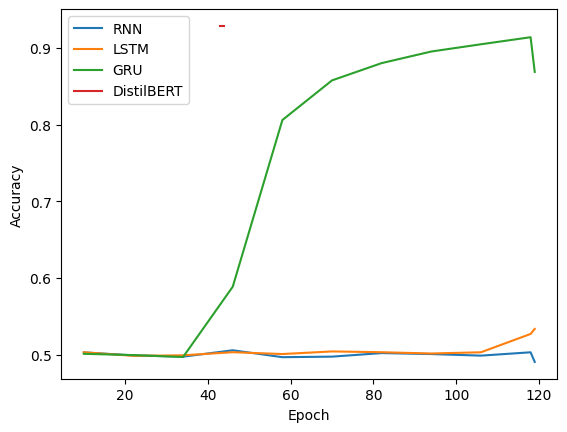

In [ ]:
perf_rnn = pd.read_csv('./logs/rnn/version_0/metrics.csv')
perf_lstm = pd.read_csv('./logs/lstm/version_0/metrics.csv')
perf_gru = pd.read_csv('./logs/gru/version_0/metrics.csv')
perf_distilbert = pd.read_csv('./logs/distilbert/version_0/metrics.csv')

val_acc = pd.concat([
    perf_rnn.val_acc.dropna(),
    perf_lstm.val_acc.dropna(),
    perf_gru.val_acc.dropna(),
    perf_distilbert.val_acc.dropna()
    ], axis=1)

fig = plt.figure()
ax = fig.gca()
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
val_acc.columns = ['rnn', 'lstm', 'gru', 'distilbert']
val_acc.plot(ax=ax)
ax.legend(['RNN', 'LSTM', 'GRU', 'DistilBERT'])
plt.show()

**Quick note:** The models did not run 120 epochs, but because of the way we set up the logging, PyTorch logged the val_acc after every batch. So 10 epochs with a batch size of 164 will cap around 120 batches.

Here are some key takeaways on the model comparisons:

- Each model performed the way we expected them to: RNN → LSTM → GRU → DistilBERT
- DistilBERT is a short line becuase it only trained for one epoch. We did this because:
  - It has 67 million parameters.
  - It is already pre-trained on a large corpus of data.

## References

1. De Silva, M. (2023, April 30). *Preprocessing Steps for Natural Language Processing (NLP): A Beginner’s Guide*. Medium. [https://medium.com/@maleeshadesilva21/preprocessing-steps-for-natural-language-processing-nlp-a-beginners-guide-d6d9bf7689c9](https://medium.com/@maleeshadesilva21/preprocessing-steps-for-natural-language-processing-nlp-a-beginners-guide-d6d9bf7689c9)

2. Lightning.ai. (n.d.). *Fine-tune Transformers Models with PyTorch Lightning*. Lightning.ai. [https://lightning.ai/lightning-ai/environments/text-classification-with-pytorch-lightning?section=featured](https://lightning.ai/lightning-ai/environments/text-classification-with-pytorch-lightning?section=feat)

